# State Farm Distracted Driver Detection

In this notebook, we'll look into how to detect a distracted driver in a car using Kaggle's dataset.

## Problem Statement

Given a set of labelled images belonging to different classes, train a model on this data to predict the class of test images. Your goal is to predict the likelihood of what the driver is doing in each picture. 

The 10 classes to predict are:

* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

## Approach to the problem


We'll consider two scenarios,

*   Using a vanilla CNN
*   Using Transfer Learning (CNN with VGG16, pretrained model)

## Dataset

Download the dataset from [here](https://www.kaggle.com/c/state-farm-distracted-driver-detection/data)


## Let's get started!

Let us structure the whole code , so that it would it easier to understand. This is how we are going to break it down.

## Vanilla CNN 

For simple CNN model, a notebook was not implemented as the main focus was on the optimal solution. Please refer to the cnn folder in the repo, to find an implementation of it.

## Transfer Learning (CNN + VGG16)

In this process, we obtain deep features from the VGG model using our data and build a model on top of the pre-trianed VGG model. Output of VGG would be input of the top model. We extract bottle-neck features from the VGG and pass it on to the top model.In this case, we are using VGG16 model.

### Import Dependencies

In [3]:
import os
import numpy as np
import operator
import matplotlib.pyplot as plt
from math import ceil
import itertools
import csv
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras import applications
from keras.utils.np_utils import to_categorical

C:\Users\Aditya Gannavarapu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Initialize required arguments

In [14]:
class_labels = ['safe_driving', 'texting_right', 'talking_on_phone_right', 'texting_left', 'talking_on_phone_left',
                'operating_radio', 'drinking', 'reaching_behind', 'doing_hair_makeup', 'talking_to_passanger']
csv_header = ['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
class_labels_encoded = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
all_entries = []
NUM_CLASSES = 10
data_path = './data/train/'
target_size = 224, 224
batch_size = 16
num_classes = len(class_labels)
filename = 'predictions.csv'

### Pre-processing the dataset

After downloading the dataset, extract to find two folders, train and test. Place them in a folder 'data'.
* We'll split the train data into three parts (train, test, validation) - (60, 20 ,20) 
* Below cell creates three folders train, test, validation

In [8]:
for i in range(NUM_CLASSES):
    
    curr_dir_path = data_path + 'c' + str(i) + '/'
    
    xtrain = labels = os.listdir(curr_dir_path)
    
    x, x_test, y, y_test = train_test_split(xtrain,labels,test_size=0.2,train_size=0.8)
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25,train_size =0.75)
    
    for x in x_train:
        
        if (not os.path.exists('train_split/' + 'c' + str(i) + '/')):
            os.makedirs('train_split/' + 'c' + str(i) + '/')
            
        os.rename(data_path + 'c' + str(i) + '/' + x, 'train_split/' + 'c' + str(i) + '/' + x)
        
    for x in x_test:
        
        if (not os.path.exists('test_split/' + 'c' + str(i) + '/')):
            os.makedirs('test_split/' + 'c' + str(i) + '/')
            
        os.rename(data_path + 'c' + str(i) + '/' + x, 'test_split/' + 'c' + str(i) + '/' + x)
    
    for x in x_val:
        
        if (not os.path.exists('validation_split/' + 'c' + str(i) + '/')):
            os.makedirs('validation_split/' + 'c' + str(i) + '/')
            
        os.rename(data_path + 'c' + str(i) + '/' + x, 'validation_split/' + 'c' + str(i) + '/' + x)

### Helper Functions

In [9]:
# Function to create the top_model
def create_top_model(activation_func, input_shape):
    
    model = Sequential()
    
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation=activation_func))
    
    return model

def plot_confusion_matrix(y_true, y_pred):
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    title = 'Confusion matrix'
    
    # normalize matrix
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels_encoded))
    plt.xticks(tick_marks, class_labels_encoded, rotation=0)
    plt.yticks(tick_marks, class_labels_encoded)

    threshold = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], '.2f'),
                 horizontalalignment='center',
                 color='white' if conf_matrix[i, j] > threshold else 'black')

    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Obtain features from VGG model using our train, test, validation data

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

# load vgg16 model, excluding the top fully connected layers
model = applications.VGG16(include_top=False, weights='imagenet')

# ---------- TRAINING DATA----------

# run training images through vgg and obtain its deep features (until last convolutional layer)
train_generator = datagen.flow_from_directory(
                    './train_split/',
                    target_size=target_size,
                    batch_size=batch_size,
                    class_mode=None, # data without labels
                    shuffle=False)

num_train_samples = len(train_generator.filenames)

# obtain steps required per epoch
train_steps = ceil(num_train_samples/batch_size)

# obtain deep/bottleneck features from vgg for the training data and save them
vgg_train_features = model.predict_generator(train_generator, steps=train_steps, verbose=1)
print('Saving deep features for training data...')
np.save('weights/vgg_train_features.npy', vgg_train_features)

# ---------- VALIDATION DATA----------

# run validation images through vgg and obtain its deep features (until last convolutional layer)
val_generator = datagen.flow_from_directory(
                    './validation_split/',
                    target_size=target_size,
                    batch_size=batch_size,
                    class_mode=None, # data without labels
                    shuffle=False)

num_val_samples = len(val_generator.filenames)

# obtain steps required per epoch
val_steps = ceil(num_val_samples/batch_size)

# obtain deep/bottleneck features from vgg for the validation data and save them
vgg_val_features = model.predict_generator(val_generator, steps=val_steps, verbose=1)
print('Saving deep features for validation data...')
np.save('weights/vgg_val_features.npy', vgg_val_features)

# ---------- TESTING DATA----------

# run testing images through vgg and obtain its deep features (until last convolutional layer)
test_generator = datagen.flow_from_directory(
                    './test_split/',
                    target_size=target_size,
                    batch_size=batch_size,
                    class_mode=None, # data without labels
                    shuffle=False)

num_test_samples = len(test_generator.filenames)

# obtain steps required per epoch
test_steps = ceil(num_test_samples/batch_size)

# obtain deep/bottleneck features from vgg for the testing data and save them
vgg_test_features = model.predict_generator(test_generator, steps=test_steps, verbose=1)
print('Saving deep features for testing data...')
np.save('weights/vgg_test_features.npy', vgg_test_features)

### Training the model

* After extracting the features from VGG16 and saving them, now we train our top_model with train and validation data
* The generator will read pictures found in subfolders and indefinitely generate batches of augmented image data
* Save the weights into a file

In [ ]:
epochs = 50
datagen = ImageDataGenerator(rescale=1./225) # Generate batches of augmented image data 

# ---------- LOAD TRAINING DATA ----------

# create datagen and train generator to load the data from directory
train_generator = datagen.flow_from_directory(
                            './train_split/',
                            target_size=target_size,
                            batch_size=batch_size,
                            class_mode='categorical',
                            shuffle=False) # data is ordered
                            
num_train_samples = len(train_generator.filenames)

# load vgg features
train_data = np.load('weights/vgg_train_features.npy')

train_labels = train_generator.classes
train_labels_onehot = to_categorical(train_labels, num_classes=num_classes)

# ---------- LOAD VALIDATION DATA ----------

# create datagen and train generator to load the data from directory
val_generator = datagen.flow_from_directory(
                            './validation_split/',
                            target_size=target_size,
                            batch_size=batch_size,
                            class_mode='categorical',
                            shuffle=False) # data is ordered
                            
num_val_samples = len(val_generator.filenames)

# load vgg features
val_data = np.load('weights/vgg_val_features.npy')

val_labels = val_generator.classes
val_labels_onehot = to_categorical(val_labels, num_classes=num_classes)

# ---------- CREATE AND TRAIN MODEL ----------

# create the top model to be trained
model = create_top_model("softmax", train_data.shape[1:])
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

# only save the best weights. if the accuracy doesnt improve in 2 epochs, stop.
checkpoint_callback = ModelCheckpoint(
                        "weights/_top_model_weights.h5", # store weights with this file name
                        monitor='val_acc',
                        verbose=1,
                        save_best_only=True,
                        mode='max')

early_stop_callback = EarlyStopping(
                        monitor='val_acc',
                        patience=2, # max number of epochs to wait
                        mode='max') 

callbacks_list = [checkpoint_callback, early_stop_callback]

# train the model
history = model.fit(
            train_data,
            train_labels_onehot,
            epochs=epochs,
            batch_size=batch_size,
            # validation_data=val_data,
            validation_data=(val_data, val_labels_onehot),
            callbacks=callbacks_list)

### Testing the model

* For testing, use the test features obtained from VGG16 and generator will read pictures found in subfolders and indefinitely generate batches of augmented image data
* Using the weights of the model that we saved, calculate accuracy and plot the confusion matrix

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0) 
test_generator = datagen.flow_from_directory(
                        './test_split/', 
                        target_size=target_size,
                        batch_size=batch_size,
                        class_mode='categorical', # specify categorical
                        shuffle=False) # data is ordered

# load vgg features
test_data = np.load('weights/vgg_test_features.npy')

test_labels = test_generator.classes # actual class number
test_labels_onehot = to_categorical(test_labels, num_classes=num_classes) # class number in onehot

# ---------- TEST MODEL ----------

model = create_top_model("softmax", test_data.shape[1:])
model.load_weights("weights/_top_model_weights.h5")  

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

predicted = model.predict_classes(test_data)

# ---------- DISPLAY INFORMATION ----------

if args.acc:
    loss, acc = model.evaluate(test_data, test_labels_onehot, batch_size=batch_size, verbose=1)
    print("loss: ", loss)
    print("accuracy: {:8f}%".format(acc*100))

if args.cm:
    plot_confusion_matrix(test_labels, predicted)

### Checking the predictions of the model

* Let's test it for an image from the test folder and see the results


1. texting_left: 100.000000%
2. talking_on_phone_left: 0.000000%
3. texting_right: 0.000000%
4. safe_driving: 0.000000%
5. drinking: 0.000000%
6. doing_hair_makeup: 0.000000%
7. talking_to_passanger: 0.000000%
8. operating_radio: 0.000000%
9. talking_on_phone_right: 0.000000%


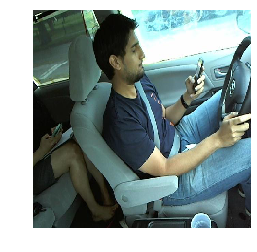

In [13]:
img_path = './test_split/c3/img_216.jpg'

# prepare image for classification using keras utility functions
image = load_img(img_path, target_size=target_size)

image_arr = img_to_array(image) # convert from PIL Image to NumPy array
image_arr /= 255

# to be able to pass it through the network and use batches, we want it with shape (1, 224, 224, 3)
image_arr = np.expand_dims(image_arr, axis=0)
# print(image.shape)

# build the VGG16 network  
model = applications.VGG16(include_top=False, weights='imagenet')  

# get the bottleneck prediction from the pre-trained VGG16 model  
bottleneck_features = model.predict(image_arr) 

# build top model  
model = create_top_model("softmax", bottleneck_features.shape[1:])

model.load_weights("weights/_top_model_weights.h5")

predicted = model.predict(bottleneck_features)
decoded_predictions = dict(zip(class_labels, predicted[0]))
decoded_predictions = sorted(decoded_predictions.items(), key=operator.itemgetter(1), reverse=True)

print()
count = 1
for key, value in decoded_predictions[:9]:
    print("{}. {}: {:8f}%".format(count, key, value*100))
    count += 1
    
    # print image
plt.imshow(image)
plt.axis('off')
plt.show()

## Preparing a Kaggle Submission

### Helper Functions

In [11]:
def predict_class(img_path):
    
    # prepare image for classification using keras utility functions
    image = load_img(img_path, target_size=target_size)

    image_arr = img_to_array(image) # convert from PIL Image to NumPy array
    image_arr /= 255

    # to be able to pass it through the network and use batches, we want it with shape (1, 224, 224, 3)
    image_arr = np.expand_dims(image_arr, axis=0)
    # print(image.shape)

    # build the VGG16 network  
    model = applications.VGG16(include_top=False, weights='imagenet')  

    # get the bottleneck prediction from the pre-trained VGG16 model  
    bottleneck_features = model.predict(image_arr) 

    # build top model  
    model = create_top_model("softmax", bottleneck_features.shape[1:])

    model.load_weights("weights/_top_model_weights.h5")

    predicted = model.predict(bottleneck_features)
    # predicted_onehot = to_categorical(predicted, num_classes=num_classes)

    return np.asarray(predicted[0]) # float32

### Preparing the CSV file for submission

This would save the predictions of all the test images of the Kaggle dataset into a CSV file.

In [ ]:
data_path = './data/test/'

for i, file in enumerate(os.listdir(data_path)):
    file_name = os.fsdecode(file)

    if file_name.endswith(".jpg"):
        
        print(i, " ", file_name, "...")
        img_path = (os.path.join(data_path, file_name))
        
        predicted = predict_class(img_path)
        predicted = np.asarray(['%.1f'%num for num in predicted]).astype('str')
        
        entry = np.concatenate((np.array([file_name]), predicted))
        all_entries.append(entry)
        
all_entries = (np.asarray(all_entries))
all_entries = all_entries[np.argsort(all_entries[:,0])]

with open(filename, 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    filewriter.writerow(csv_header)
    for row in all_entries:
        filewriter.writerow(row)

## Kaggle Submission score

Got a score of public score of 0.24258 and a private score of 0.23779 after submitting the solution

<img src="submission/kaggle.png">